<a href="https://colab.research.google.com/github/Kuppamshireesha/Simple-Baselines-for-Image-and-Video-Restoration/blob/main/Copy_of_NAFNet_demo_on_Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAFNet on Image Denoising and Video Restoration.

## Git clone [NAFNet](https://github.com/megvii-research/NAFNet) repo

In [1]:
!git clone https://github.com/megvii-research/NAFNet
%cd NAFNet

Cloning into 'NAFNet'...
remote: Enumerating objects: 521, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 521 (delta 180), reused 142 (delta 142), pack-reused 296
Receiving objects: 100% (521/521), 16.19 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (277/277), done.
/content/NAFNet


## Set up the enviroment

In [2]:
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!python3 setup.py develop --no_cuda_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 33.1 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        **************************************************************************

## Download pretrained models

In [3]:
import gdown
gdown.download('https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR', "./experiments/pretrained_models/", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR
From (redirected): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR&confirm=t&uuid=f4146da8-8c1f-45f5-a7d4-c0546d680430
To: /content/NAFNet/experiments/pretrained_models/NAFNet-SIDD-width64.pth
100%|██████████| 464M/464M [00:08<00:00, 57.9MB/s]


'./experiments/pretrained_models/NAFNet-SIDD-width64.pth'

## Download Demo Image and Video


In [4]:
gdown.download('https://drive.google.com/uc?id=1uKwZUgeGfBYLlPKllSuzgGUItlzb40hm', "demo_input/", quiet=False)
gdown.download('https://drive.google.com/uc?id=1ov6UqpIA6GjjJT5SdGeUAJECxka14nGf', "demo_input/", quiet=False)
gdown.download('https://drive.google.com/file/d/1dwL8wIOYlcm0ONDjfQVAmR0XtCwYszf5/view?usp=sharing', "demo_input/", quiet=False)
gdown.download('https://drive.google.com/file/d/1TwIYxAwec2ZT00ANfB6fSuO1l2d0zTvh/view?usp=sharing', "demo_input/", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1uKwZUgeGfBYLlPKllSuzgGUItlzb40hm
To: /content/NAFNet/demo_input/noisy-demo-0.png
100%|██████████| 171k/171k [00:00<00:00, 26.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ov6UqpIA6GjjJT5SdGeUAJECxka14nGf
To: /content/NAFNet/demo_input/noisy-demo-1.png
100%|██████████| 150k/150k [00:00<00:00, 85.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1dwL8wIOYlcm0ONDjfQVAmR0XtCwYszf5
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1dwL8wIOYlcm0ONDjfQVAmR0XtCwYszf5/view?usp=sharing
To: /content/NAFNet/demo_input/view?usp=sharing
82.3kB [00:00, 15.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download 

'demo_input/view?usp=sharing'

## Preparation

In [5]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('NAFNet output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)


In [6]:
import torch
from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import HTML
import io
import base64
# Define the function for video restoration with display option
def video_restoration(model, input_video_path, output_video_path, display=False):
    cap = cv2.VideoCapture(input_video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert frame to tensor
        frame_tensor = img2tensor(frame_rgb)

        # Perform inference for single frame
        #single_frame_inference(model, frame_tensor, output_path)

        # Convert tensor back to image
        restored_frame = imread(output_path)

        # Write restored frame to output video
        out.write(restored_frame)

        # Display restored frame if required
        if display:
            cv2.imshow('Restored Video', restored_frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

    cap.release()
    out.release()


## Create Model

In [7]:
opt_path = 'options/test/SIDD/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFNet = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7db629a9abc0>


# Inference and Show results

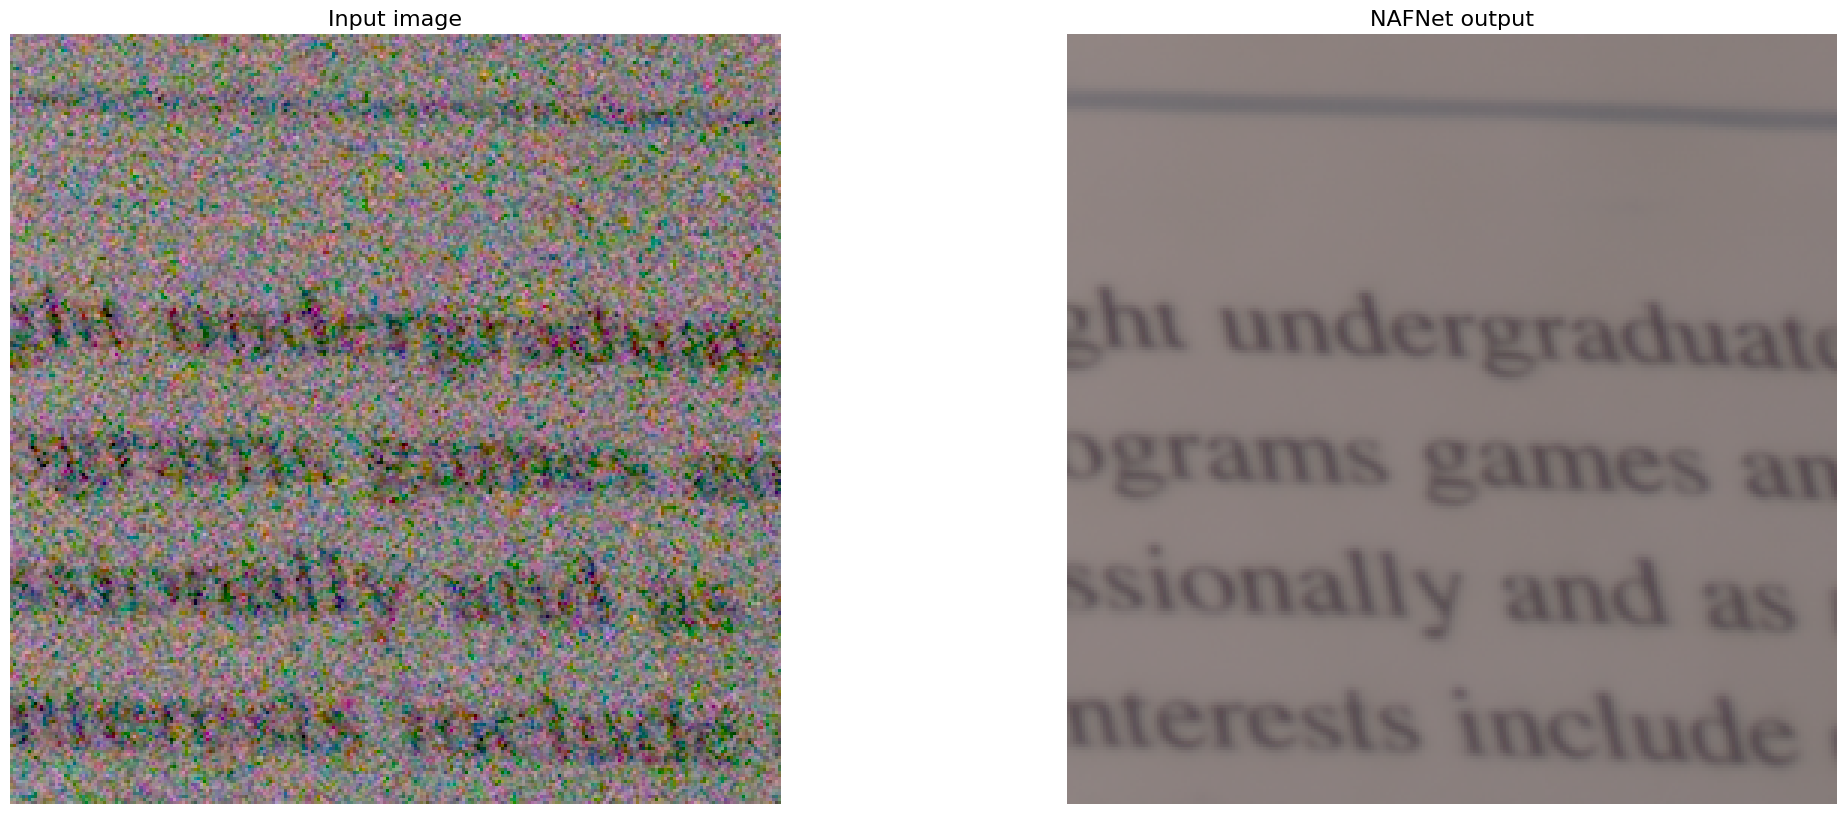

In [8]:
input_path = 'demo_input/noisy-demo-0.png'
output_path = 'demo_output/noisy-demo-0.png'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

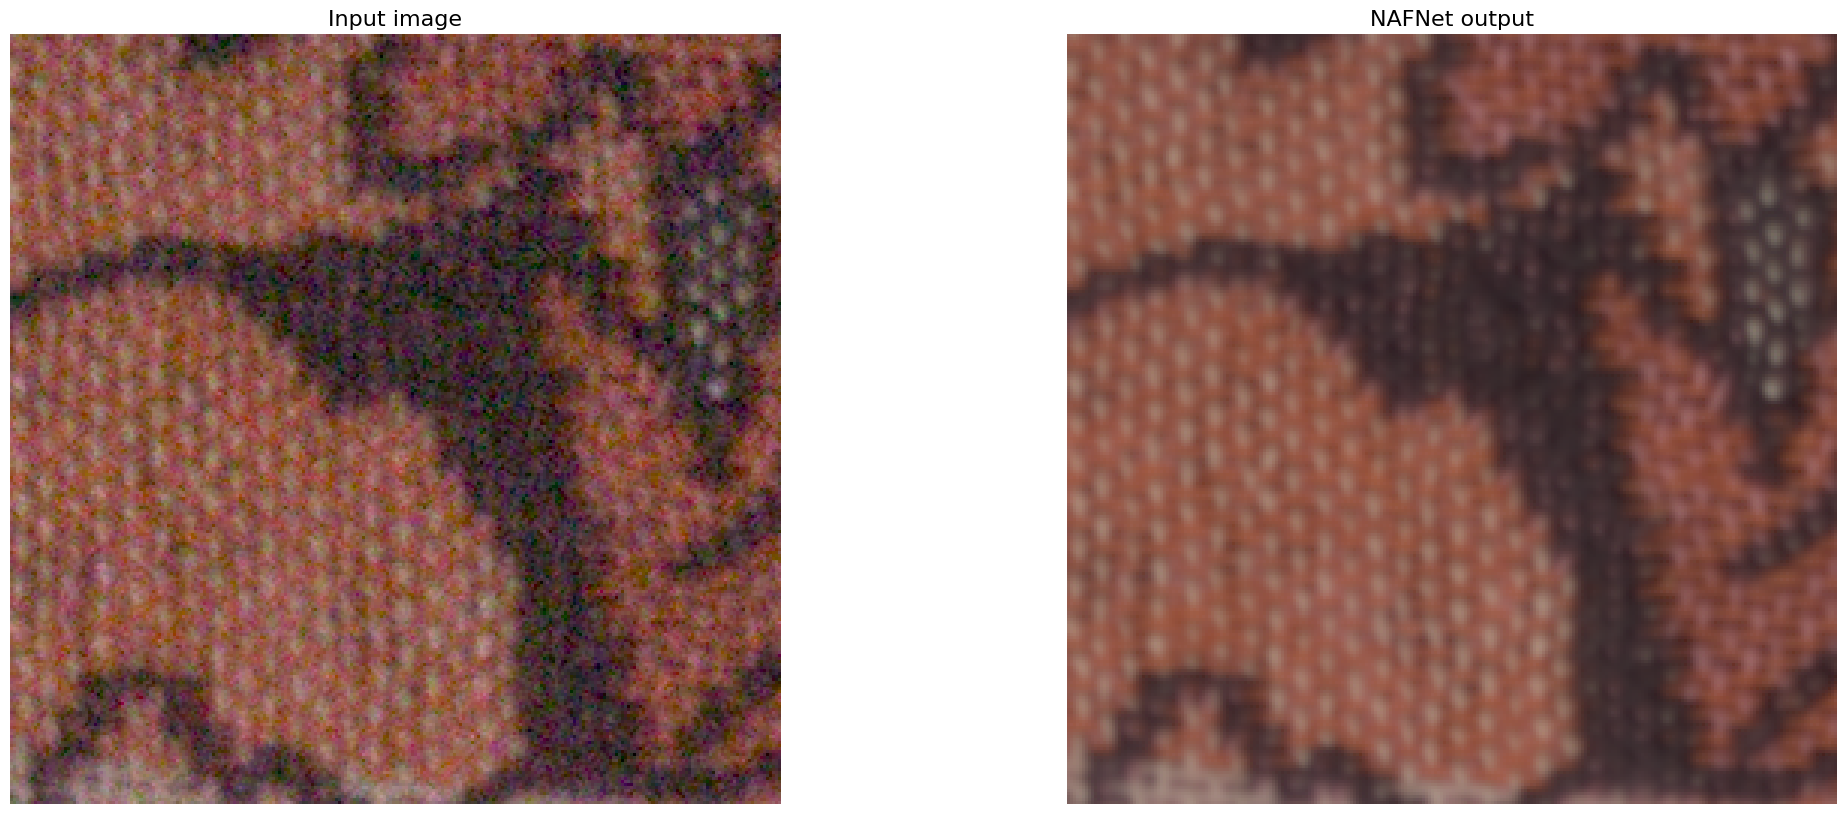

In [9]:
input_path = 'demo_input/noisy-demo-1.png'
output_path = 'demo_output/noisy-demo-1.png'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

In [10]:
#Video Demo
input_video_path = 'demo_input/blur-video.mp4'
output_video_path = 'demo_output/blur-video.mp4'

# Perform video restoration with display
video_restoration(NAFNet, input_video_path, output_video_path, display=True)

# Try it on uploaded images

## 1. Upload images

In [11]:
import os
from google.colab import files
import shutil

upload_folder = 'upload/input'
result_folder = 'upload/output'

# Clean up existing folders and create new ones
if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.makedirs(upload_folder)
os.makedirs(result_folder)

# Upload images
uploaded = files.upload()
for filename in uploaded.keys():
    # Move uploaded images to input folder
    src_path = filename
    dst_path = os.path.join(upload_folder, filename)
    shutil.move(src_path, dst_path)
    print(f'Moved {filename} to {dst_path}')

# Process the images (Example: Move from input to output folder)
input_images = os.listdir(upload_folder)
for input_image in input_images:
    input_path = os.path.join(upload_folder, input_image)
    output_path = os.path.join(result_folder, input_image)
    # Example: Move input image to output folder (replace with your processing logic)
    shutil.copy(input_path, output_path)
    print(f'Processed {input_image} and saved to {output_path}')


Saving img.jpg to img.jpg
Moved img.jpg to upload/input/img.jpg
Processed img.jpg and saved to upload/output/img.jpg


## Inference

In [12]:
import glob
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  inp = img2tensor(img_input)
  output_path = os.path.join(result_folder, os.path.basename(input_path))
  #single_image_inference(NAFNet, inp, output_path)

## 3. Visualize (Optional)

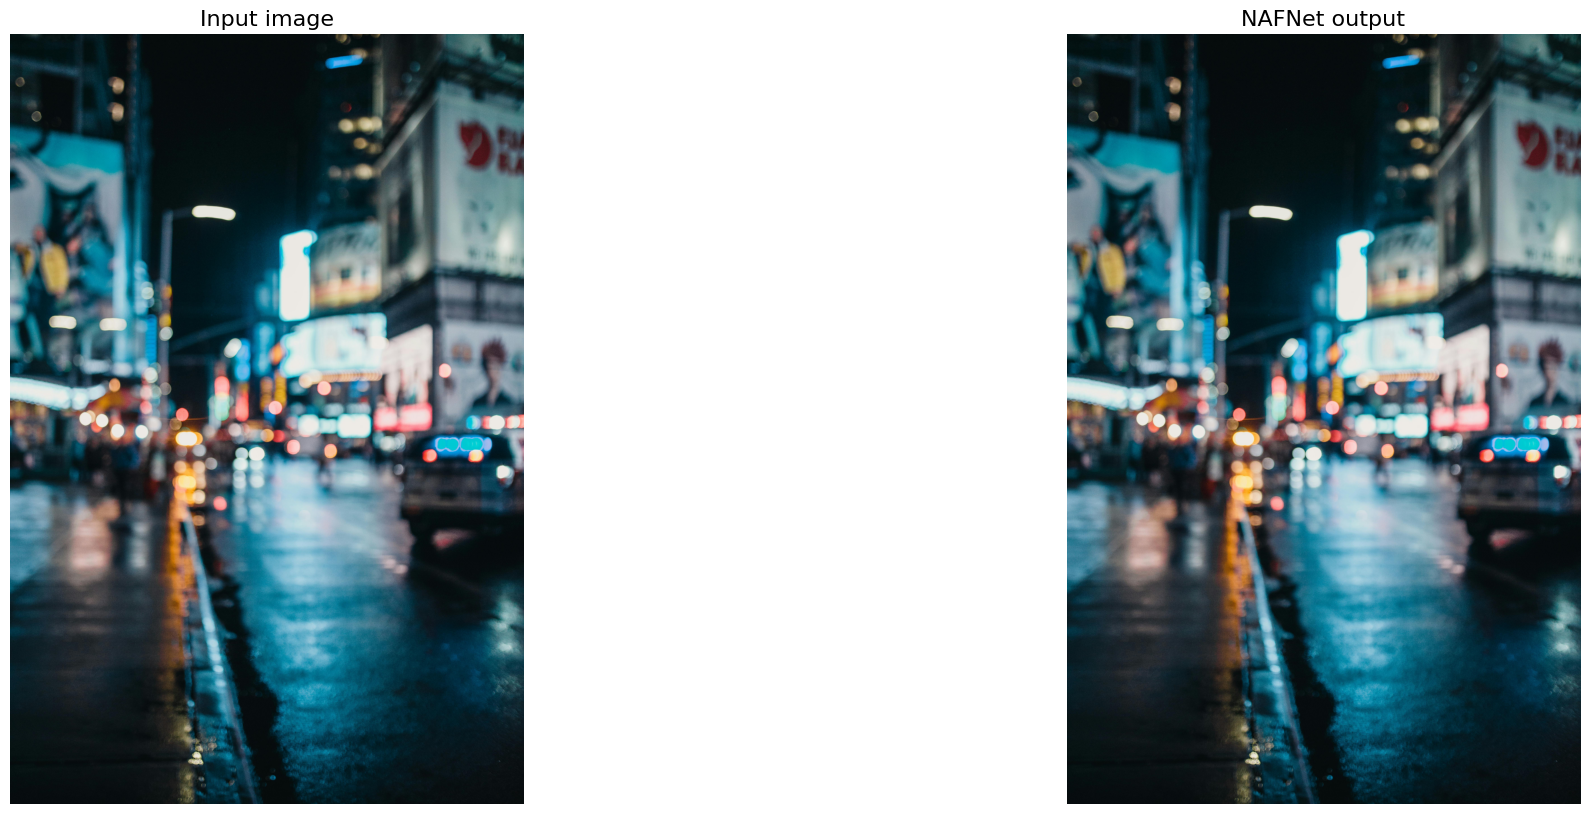

In [13]:
# visualize
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

## 4. Download results

In [14]:
# download the result
print(f'Download {result_folder}')
os.system(f'zip -r -j download.zip {result_folder}/*')
files.download("download.zip")

Download upload/output


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>